## Sales Transactions

This project consists in a forecasting task. I used a dataset hosted in UCI Machine Learning Repository. It can be downloaded in https://archive.ics.uci.edu/ml/datasets/Sales_Transactions_Dataset_Weekly.

This dataset contains data of sales of 810 products, splitted in 52 weeks. The main goal of this project is to predict the sales for 1 week ahead for each product.

This project will show a simple solution for a time series problem.

In [ ]:
# Importing the libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Loading the train dataset
df=pd.read_csv('/content/Sales_Transactions_Dataset_Weekly.csv')

In [ ]:
df.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,P1,11,12,10,8,13,12,14,21,6,...,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,P2,7,6,3,2,7,1,6,3,3,...,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,P3,7,11,8,9,10,8,7,13,12,...,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,P4,12,8,13,5,9,6,9,13,13,...,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,P5,8,5,13,11,6,7,9,14,9,...,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40


The dataset contains 107 columns, as that is shown below:

- 1 Column with the product codes;
- 52 Columns with each week sales with absolute values;
- 1 Column with the Max quantity and 1 with the Min qunatity of sales per product;
- 52 Columns with Normalized values for the sales per Product.

There are computed the sales for 810 products.

First of all, let's investigate the type of normalization used.


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
test_norm=pd.DataFrame(scaler.fit_transform(df.iloc[1,1:53].values.reshape(-1,1))) 
test_norm2=pd.DataFrame(df.iloc[1,55:].values)                                                                  
(test_norm-test_norm2).value_counts()

0.000000e+00    32
1.110223e-16    11
5.551115e-17     9
dtype: int64

As we can see it was used the MaxMinScaler from SKLearn.



##  EDA and Data Prepocessing

As the project consists in a time series one, to get to know the trend and seasonality among the weeks, let's see the graphic of the progression of the sales.

As we are analyzing different products with diferent scales, to understand the sales behavior we are going to use the normalized data.


In [ ]:
#Splitting the datased in normalized and absolute data.
df_norm=df.filter(regex=r'Product|Normalize')
df_abs=df.filter(regex=r'Product|W')

In [ ]:
#There are not NaN values in the dataset.
df_norm.isnull().sum(), df_abs.isnull().sum()

(Product_Code     0
 Normalized 0     0
 Normalized 1     0
 Normalized 2     0
 Normalized 3     0
 Normalized 4     0
 Normalized 5     0
 Normalized 6     0
 Normalized 7     0
 Normalized 8     0
 Normalized 9     0
 Normalized 10    0
 Normalized 11    0
 Normalized 12    0
 Normalized 13    0
 Normalized 14    0
 Normalized 15    0
 Normalized 16    0
 Normalized 17    0
 Normalized 18    0
 Normalized 19    0
 Normalized 20    0
 Normalized 21    0
 Normalized 22    0
 Normalized 23    0
 Normalized 24    0
 Normalized 25    0
 Normalized 26    0
 Normalized 27    0
 Normalized 28    0
 Normalized 29    0
 Normalized 30    0
 Normalized 31    0
 Normalized 32    0
 Normalized 33    0
 Normalized 34    0
 Normalized 35    0
 Normalized 36    0
 Normalized 37    0
 Normalized 38    0
 Normalized 39    0
 Normalized 40    0
 Normalized 41    0
 Normalized 42    0
 Normalized 43    0
 Normalized 44    0
 Normalized 45    0
 Normalized 46    0
 Normalized 47    0
 Normalized 48    0


In [ ]:
#Let's see the progression of sales among the weeks using the summation of the products per week.
df_sum=pd.DataFrame(np.zeros(52))
linha=0
for linha in range (0,52):
  df_sum.iloc[linha,0]=df_norm.iloc[:,linha+1].sum()
 


Text(0.5, 1.0, 'Sales Over the year')

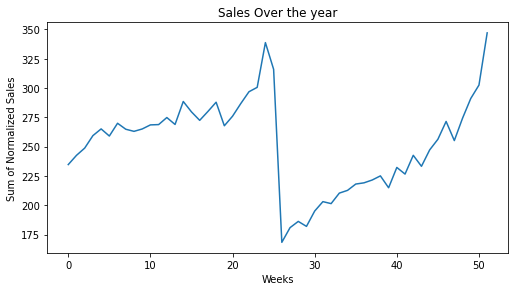

In [ ]:
#Representing graphically.
fig = plt.figure(figsize=(8,4))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) 
axes.plot(df_sum)
axes.set_xlabel('Weeks') 
axes.set_ylabel('Sum of Normalized Sales')
axes.set_title('Sales Over the year')

In [ ]:
#Descriptive Statistics
df_sum.describe()

,0
count,52.000000
mean,253.136923
std,39.334245
min,168.360000
25%,224.167500
50%,261.220000
75%,275.112500
max,347.060000


From the graphic above we can clearly see that the sales start small and keep growing till half of the year. Then the sales get really lower and again start growing till it's gets the higher point.

We can see the presence of a trend and seasonality, so let's enginner some features to capt these particularities.

We are going to have a prediction for product for week, that's 811*52 predictions, 42.172 predictions. To have one prediction for row, let's melt the data.

In [ ]:
df_abs_melt=df_abs.melt(id_vars='Product_Code', var_name='Week', value_name= 'Sales')

In [ ]:
#As we assumed, we have 42172 predictions.
df_abs_melt.shape

(42172, 3)

To split the data, I want to capt the trend an seasonality, and for that I will split the data in the beginning of the second season. Taking 80% of the dataset to train we get around the 42th week.

In [ ]:
train_df=df_abs_melt.iloc[0:df_abs_melt.loc[df_abs_melt['Week']=='W42'].index[0]]
val_df=df_abs_melt.iloc[df_abs_melt.loc[df_abs_melt['Week']=='W42'].index[0]:]
train_df.shape, val_df.shape

((34062, 3), (8110, 3))

Let's create a feature with the sales for next week. This one will be our target.

In [ ]:
train_df['Sales_Next_Week']=train_df.groupby('Product_Code')['Sales'].shift(-1)
val_df['Sales_Next_Week']=val_df.groupby('Product_Code')['Sales'].shift(-1)

Let's start the feature engeneering!

In [ ]:
# 1 - Lag - Last period value (The W0 and W42 are going to contain NaNs).
train_df['Lag']=train_df.groupby('Product_Code')['Sales'].shift(+1)
val_df['Lag']=val_df.groupby('Product_Code')['Sales'].shift(+1)

In [ ]:
# 2 - Difference - Difference in relation to the last period.
train_df['Dif']=train_df.groupby('Product_Code')['Sales'].diff(+1)
val_df['Dif']=val_df.groupby('Product_Code')['Sales'].diff(+1)

 In a Time Series problem, it is common to use the Rolling Statistics, for instance:

-Mean

-Max

-Min

-Std

In this particular problem I will only use the mean of the last 4 periods.

In [ ]:
# 3- Mean of the last 4 periods.
train_df['Mean']=train_df.groupby('Product_Code')['Sales'].rolling(4).mean().reset_index(level=0, drop=True)
val_df['Mean']=val_df.groupby('Product_Code')['Sales'].rolling(4).mean().reset_index(level=0, drop=True)

In [ ]:
#4 - Linear Regression for the 4 last periods.
from sklearn.linear_model import LinearRegression
lin_model=LinearRegression()
train_df['Reg_Lin_Next_Sale']=0
produto=train_df['Product_Code'].unique()
for x in produto:
  for linha in range(4,43):
 
    ylin=train_df.loc[train_df['Product_Code']==x,'Sales'].iloc[linha-4:linha]
    xlin=np.array([1,2,3,4]).reshape(-1,1)
    lin_model.fit(xlin,ylin)
    train_df.loc[(train_df['Product_Code']==x)&(train_df['Week']=='W{}'.format(linha-1)), 'Reg_Lin_Next_Sale']=lin_model.predict(np.array(5).reshape(-1,1))
  

In [ ]:
val_df['Reg_Lin_Next_Sale']=0
produto=val_df['Product_Code'].unique()
for x in produto:
  for linha in range(4,11):  
    ylin=val_df.loc[val_df['Product_Code']==x,'Sales'].iloc[linha-4:linha]
    xlin=np.array([1,2,3,4]).reshape(-1,1)
    lin_model.fit(xlin,ylin)
    val_df.loc[(val_df['Product_Code']==x)&(val_df['Week']=='W{}'.format(linha+41)), 'Reg_Lin_Next_Sale']=lin_model.predict(np.array(5).reshape(-1,1))


In [ ]:
# Dropping the NaN.
train_df.dropna(inplace=True)
val_df.dropna(inplace=True)

# Defining our Baseline

Before Creating the model, we have to define how we are going to calculate the Baseline, that is essential to evaluate it. Let's assume as a Baseline that the sales of the next week are going to be the same as the sales of the current week.

As there are some Sales with a 0, the MAPE can't be calculate, so let's calculate the WMAPE (weighted mean absolute percentage error).

In [ ]:
#WMAPE for the Baseline
np.sum(np.abs(train_df['Sales']-train_df['Sales_Next_Week'])/np.sum(np.abs(train_df['Sales']))), np.sum(np.abs(val_df['Sales']-val_df['Sales_Next_Week'])/np.sum(np.abs(val_df['Sales'])))

(0.3086110980407771, 0.31761576308293515)

The WMAPE of the Baseline using the validation dataset is 0.3176.

# Creating and Training the Model

In [ ]:
features=['Sales', 'Lag', 'Dif', 'Mean', 'Reg_Lin_Next_Sale']
x_train=train_df[features]
x_val=val_df[features]
y_train=train_df['Sales_Next_Week']
y_val=val_df['Sales_Next_Week']

There are several machine learning alghoritms that could be used to build our model. We decided to use the RandomForestRegressor.

For the hiperparameter tuning we are going to use the RandomizedSearchCV.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
param_grid = {'max_depth': [3,4,5,6,7,8,9,10], 'min_samples_leaf': [10,20,30,40,50], 'max_features': ['int','float','auto','log2']} 
model= RandomizedSearchCV(RandomForestRegressor(),param_grid,n_iter=20,refit=True,verbose=3, 
                              scoring='neg_mean_absolute_percentage_error', random_state=42)
model.fit(x_train,y_train)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END max_depth=8, max_features=float, min_samples_leaf=10;, score=nan total time=   0.1s
[CV 2/5] END max_depth=8, max_features=float, min_samples_leaf=10;, score=nan total time=   0.1s
[CV 3/5] END max_depth=8, max_features=float, min_samples_leaf=10;, score=nan total time=   0.2s
[CV 4/5] END max_depth=8, max_features=float, min_samples_leaf=10;, score=nan total time=   0.1s
[CV 5/5] END max_depth=8, max_features=float, min_samples_leaf=10;, score=nan total time=   0.1s
[CV 1/5] END max_depth=8, max_features=float, min_samples_leaf=40;, score=nan total time=   0.2s
[CV 2/5] END max_depth=8, max_features=float, min_samples_leaf=40;, score=nan total time=   0.1s
[CV 3/5] END max_depth=8, max_features=float, min_samples_leaf=40;, score=nan total time=   0.1s
[CV 4/5] END max_depth=8, max_features=float, min_samples_leaf=40;, score=nan total time=   0.1s
[CV 5/5] END max_depth=8, max_features=float, min_samples_leaf=40;,

RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=5,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'max_features': ['int', 'float', 'auto',
                                                         'log2'],
                                        'min_samples_leaf': [10, 20, 30, 40,
                                                             50]},
                   random_state=42,
                   scoring='neg_mean_absolute_percentage_error', verbose=3)

In [ ]:
#These are the best parameters that RandomizedSearchCV chose.
model.best_params_

In [ ]:
#Making The predicition
predictiontrain=model.predict(x_train)
predictionval=model.predict(x_val)

# Model Evaluation (WMAPE Metric)

In [ ]:
np.sum(np.abs(y_train-predictiontrain)/np.sum(np.abs(y_train))), np.sum(np.abs(y_val-predictionval)/np.sum(np.abs(y_val)))

(0.24969633751685696, 0.2754124565579399)

The Baseline brought a WMAPE of 0.3176 and our model brought a WMAPE of 0.2754, that is an improvement of more than 10%.


There are other things that could be done to improve our model, as testing new features, using a Recurrent Neural Network model, and others. We also could make a more complex validation, using the cross validation.


It's worth to mention that the horizon used in this dataset is short. We had data of only one year and could see only two trends and seasons. If we had data of a long time horizon, we would certainly do better forecasts.


That said, the main goal of this project was reached, as we got with a simple model, a big improvement in relation to a Baseline one.